### Repo

- https://www.kaggle.com/code/nageshsingh/generate-realistic-human-face-using-gan

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

### Load the data and resize the iamges

In [2]:
# PIC_DIR = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/adenosis/'

# ORIG_WIDTH = 700
# ORIG_HEIGHT = 460
# diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

# WIDTH = 128
# HEIGHT = 128

# crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

# images = []

# for pic_file in tqdm(os.listdir(PIC_DIR)):

#     pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
#     pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
#     images.append(np.uint8(pic))

In [3]:
path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/adenosis/'

WIDTH = 128
HEIGHT = 128

images = []
read = lambda imname: np.asarray(Image.open(imname).convert('L')) #'LA', 'L'

for image in os.listdir(path):

    img = read(path + "/" + image)
    # img = cv2.imread(path + folder + "/" + image)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (HEIGHT, WIDTH))

    # täusche RGB Image an damit das fürs ResNet als input verwendet werden kann
    img = np.repeat(img[..., np.newaxis], 3, -1)

    images.append(np.array(img))

In [4]:
#Image shape
images = np.array(images) / 255
print(images.shape)

(114, 128, 128, 3)


### Display first 25 images

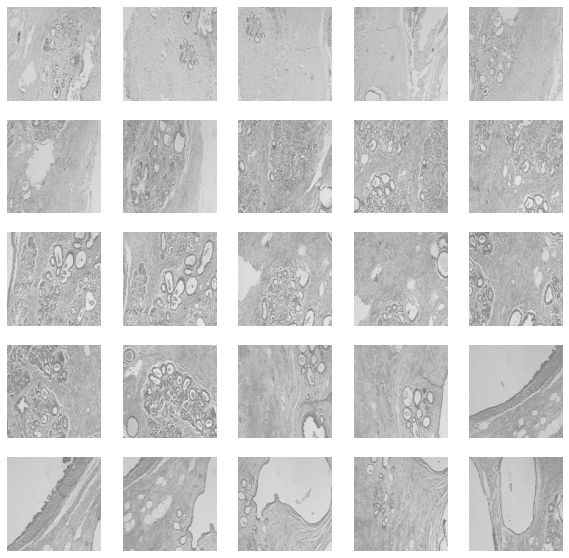

In [5]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

### The next step is to create a Generator

The generator goes the other way: It is the artist who is trying to fool the discriminator. This network consists of 8 convolutional layers. Here first, we take our input, called gen_input and feed it into our first convolutional layer. Each convolutional layer performs a convolution and then performs batch normalization and a leaky ReLu as well. Then, we return the tanh activation function.

In [6]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

### Next, create a Discriminator

The discriminator network consists of convolutional layers the same as the generator. For every layer of the network, we are going to perform a convolution, then we are going to perform batch normalization to make the network faster and more accurate and finally, we are going to perform a Leaky ReLu.

In [7]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

### Define a GAN Model

In [8]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [9]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [10]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

c:\Users\elias\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [12]:
optimizer = RMSprop(lr = .0001, clipvalue = 1.0, decay = 1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [13]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


### Training the GAN model:

In [17]:
import time

iters = 15
batch_size = 16

RES_DIR = 'gan_architecture_2'
FILE_PATH = '%s/generated_%d.png'

if not os.path.isdir(RES_DIR):

    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size = (CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):

    start_time = time.time()

    latent_vectors = np.random.normal(size = (batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size

    if start > images.shape[0] - batch_size:

        start = 0

    if step % 5 == 0: # if step % 50 == 49:

        gan.save_weights('./gan/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]

        im = Image.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


1/1 [==============================] - 10s 10s/step
1/15: d_loss: 0.6905,  a_loss: 0.7436.  (64.9 sec)
1/1 [==============================] - 13s 13s/step
6/15: d_loss: 0.7064,  a_loss: 0.6839.  (74.6 sec)
1/1 [==============================] - 12s 12s/step
11/15: d_loss: 0.6853,  a_loss: 0.6452.  (78.8 sec)
1/1 [==============================] - 13s 13s/step


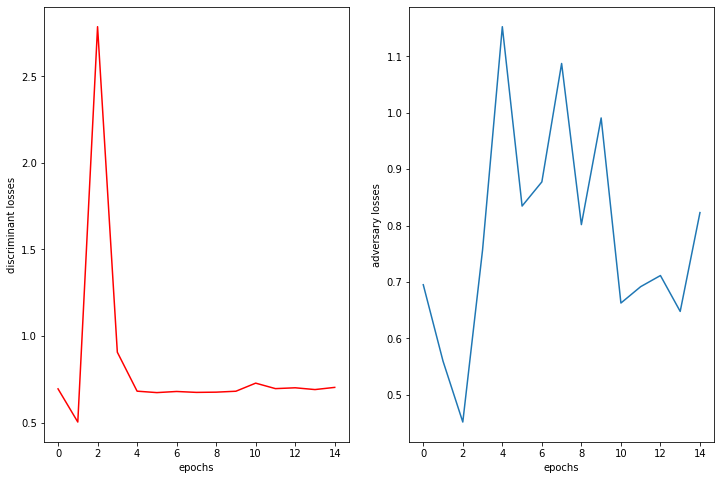

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

### Let us also make the GIF of the output images that have been generated.

In [ ]:
import imageio
import shutil

images_to_gif = []

for filename in os.listdir(RES_DIR):

    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))

imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)